RE 604 Computer Vision

In [1]:
# Import Library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.feature import hog
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split, LeaveOneOut
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils import shuffle
import seaborn as sns

In [2]:
# Dataset read in CSV format using pandas
data = pd.read_csv("emnist-letters-train.csv", header=None)

#this is the part to call the data in CSV format

In [3]:
# Take 100 random data from each class (total 26 classes = 2600 data)
sampled_data = data.groupby(0, group_keys=False).sample(n=100, random_state=42).reset_index(drop=True)

print("Jumlah total data:", len(sampled_data))
print("Jumlah data per kelas:\n", sampled_data.groupby(0).size())

# Separate features and labels
X = sampled_data.iloc[:, 1:].values
y = sampled_data.iloc[:, 0].values

# Taken 100 data from each letter class (a-z)
# the following is the total amount of data which is 2600
# and the amount of data per class

Jumlah total data: 2600
Jumlah data per kelas:
 0
1     100
2     100
3     100
4     100
5     100
6     100
7     100
8     100
9     100
10    100
11    100
12    100
13    100
14    100
15    100
16    100
17    100
18    100
19    100
20    100
21    100
22    100
23    100
24    100
25    100
26    100
dtype: int64


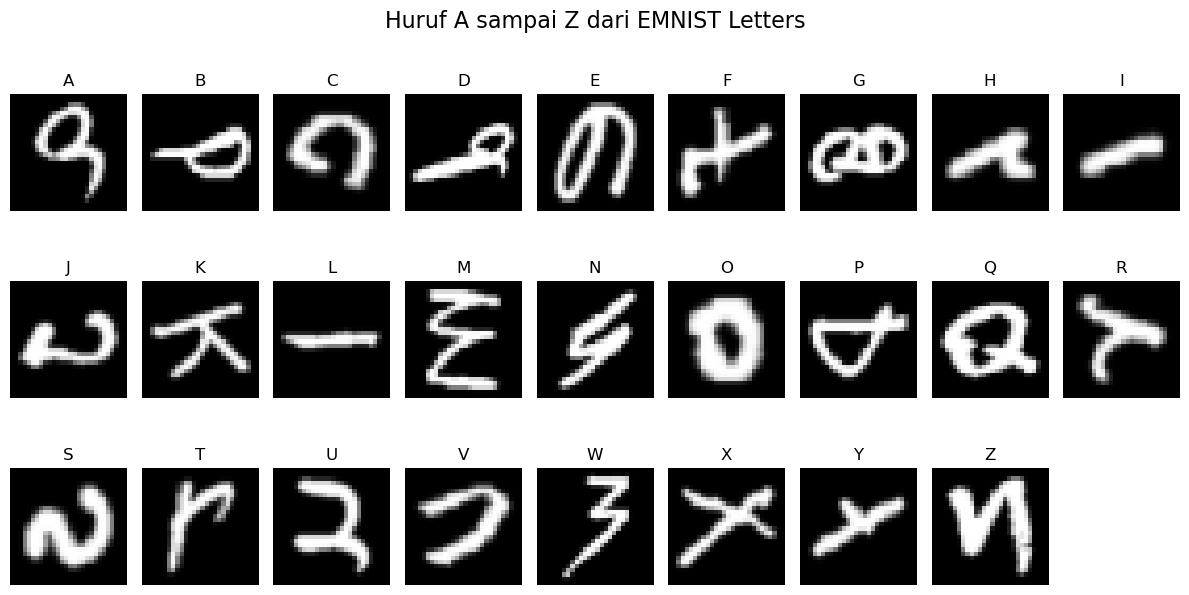

In [4]:
# Pisahkan label dan gambar
labels = sampled_data.iloc[:, 0].values
images = sampled_data.iloc[:, 1:].values.reshape(-1, 28, 28)

# Fungsi konversi label angka (1–26) menjadi huruf A–Z
def label_to_char(label):
    return chr(label + 64)  # Karena 'A' = 65 di ASCII

# Ambil satu contoh gambar untuk setiap huruf
unique_labels = np.unique(labels)
unique_images = []

for lbl in unique_labels:
    idx = np.where(labels == lbl)[0][0]
    img = images[idx]
    char = label_to_char(lbl)
    unique_images.append((img, char))

# Tampilkan semua huruf
plt.figure(figsize=(12, 6))
for i, (img, char) in enumerate(unique_images):
    plt.subplot(3, 9, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(char)
    plt.axis('off')

plt.tight_layout()
plt.suptitle("Huruf A sampai Z dari EMNIST Letters", y=1.05, fontsize=16)
plt.show()

# and this is what the resulting letters look like

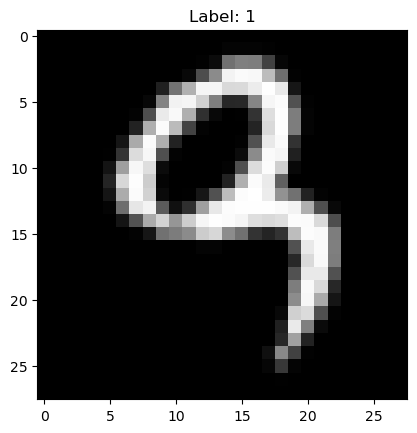

In [5]:
# Pisahkan label dan fitur
labels = sampled_data.iloc[:, 0].values
images = sampled_data.iloc[:, 1:].values.reshape(-1, 28, 28)

# Visualisasi salah satu sample 
plt.imshow(images[0], cmap='gray')
plt.title(f"Label: {labels[1]}")
plt.show()

# and the resulting lebel is the first lebel which is the letter A

HOG
* HOG features are extracted from each 28x28 image.
HOG parameters:
* orientations = 9 number of gradient direction angles
* pixels_per_cell = (8, 8) the size of the pixel area per cell
* cells_per_block = (2, 2) number of cells in a block

In [6]:
 #HOG Feature Extraction ---
hog_features = []
for img in images:
    fd = hog(img,
             orientations=9,
             pixels_per_cell=(8, 8),
             cells_per_block=(2, 2),
             block_norm='L2-Hys')
    hog_features.append(fd)

hog_features = np.array(hog_features)


LOOCV 
Dibagian ini saya train-test split 80:20 dengan stratifikasi untuk menjaga distribusi label.

In [7]:
# Split the dataset eighty percent (80%) for training and twenty percent (20%) for testing.
X_train, X_test, y_train, y_test = train_test_split(hog_features, labels, test_size=0.2, random_state=42, stratify=labels)


SVM
* Menggunakan SVC() untuk klasifikasi.

In [8]:
# Training dengan SVM
model = SVC(kernel='rbf', C=10, gamma=0.01)
model.fit(X_train, y_train)
# and the result

SVC(C=10, gamma=0.01)

In [9]:
#GridSearchCV 
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [0.001, 0.01, 0.1],
    'kernel': ['rbf']
}
grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=1, n_jobs=-1)
grid.fit(X_train, y_train)
print("Best parameters:", grid.best_params_)
model = grid.best_estimator_
# and the result

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}


In [10]:
# Inisialisasi model SVM
clf = SVC(kernel='rbf', C=10, gamma='scale')  

# Latih model dengan data training
clf.fit(X_train, y_train)

# Baru lakukan evaluasi
y_pred = clf.predict(X_test)

# Evaluasi performa
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='macro')
rec = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")
# and the result

Accuracy: 0.7808
Precision: 0.7929
Recall: 0.7808
F1 Score: 0.7803


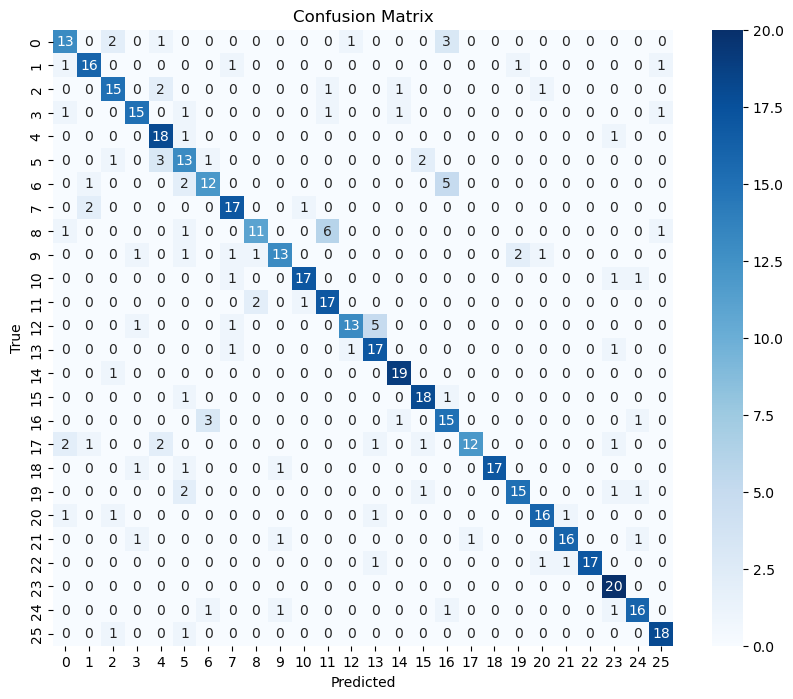

In [11]:
# Confusion Matrix --- visualisasi hasil prediksi
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
# and the result

In [12]:
from sklearn.model_selection import LeaveOneOut
from tqdm import tqdm

# X = hog_features, y = labels
loo = LeaveOneOut()
y_true = []
y_pred = []

model = SVC(C=1, kernel='linear', gamma='scale')

print("Mulai LOOCV...")
for train_index, test_index in tqdm(loo.split(hog_features), total=len(hog_features)):
    X_train, X_test = hog_features[train_index], hog_features[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    
    model.fit(X_train, y_train)
    y_pred.append(model.predict(X_test)[0])
    y_true.append(y_test[0])

Mulai LOOCV...


100%|██████████████████████████████████████████████████████████████████████████████| 2600/2600 [09:50<00:00,  4.40it/s]


In [13]:
# Evaluation of results LOOCV
print("Hasil LOOCV:")
print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred, average='macro'))
print("Recall:", recall_score(y_true, y_pred, average='macro'))
print("F1-Score:", f1_score(y_true, y_pred, average='macro'))

Hasil LOOCV:
Accuracy: 0.7684615384615384
Precision: 0.7714203077244028
Recall: 0.7684615384615386
F1-Score: 0.768692714389492
